In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 실행 결과 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 한글 깨짐 방지 (Windows 기준, Mac은 'AppleGothic')
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print("데이터 로드 완료!")
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

데이터 로드 완료!
Train Shape: (26457, 20)
Test Shape: (10000, 19)


In [33]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [18]:
def basic_preprocessing(df):
    # 1. 자녀 수가 가족 수보다 많은 경우 등 논리적 오류 수정 (필요시)
    # 2. DAYS_BIRTH, DAYS_EMPLOYED 등을 양수로 변환하여 보기 편하게 만듦
    df['age'] = df['DAYS_BIRTH'] // -365
    
    # 3. DAYS_EMPLOYED의 양수값(365243)은 실직자이므로 0으로 처리하거나 별도 표시
    df['employed_days'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else -x)
    
    # 4. begin_month도 양수로 변환
    df['begin_month'] = -df['begin_month']
    
    # 5. 불필요한 index 컬럼 삭제
    df = df.drop('index', axis=1)
    
    return df

train = basic_preprocessing(train)
test = basic_preprocessing(test)

# 결측치가 많은 occyp_type은 'None'으로 채우기
train['occyp_type'] = train['occyp_type'].fillna('None')
test['occyp_type'] = test['occyp_type'].fillna('None')

train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,employed_days
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,1,0,0,0,None,2.0,6.0,1.0,38,4709
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,1,0,0,1,Laborers,3.0,5.0,1.0,31,1540
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,...,1,0,1,0,Managers,2.0,22.0,2.0,52,4434
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,1,0,1,0,Sales staff,2.0,37.0,0.0,41,2092
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,...,1,0,0,0,Managers,2.0,26.0,2.0,41,2105


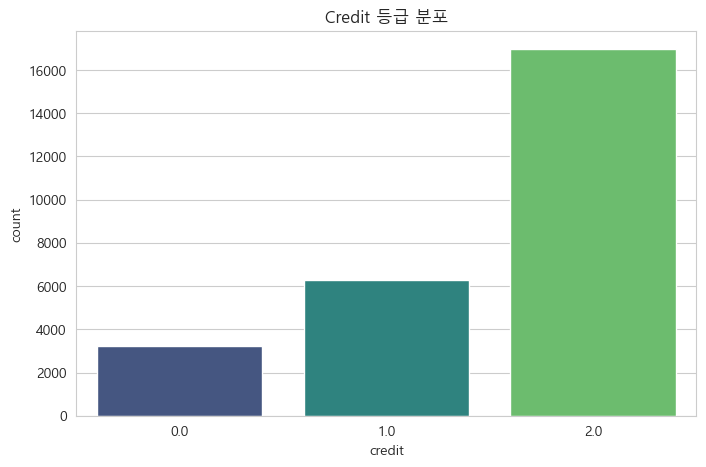

Credit 등급별 비율:
credit
2.0    64.134256
1.0    23.687493
0.0    12.178252
Name: proportion, dtype: float64


In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(x='credit', data=train, palette='viridis')
plt.title('Credit 등급 분포')
plt.show()

print("Credit 등급별 비율:")
print(train['credit'].value_counts(normalize=True) * 100)

In [39]:
# 1. 파생 변수 생성
def make_features(df):
    # 가구당 평균 소득
    df['income_per_person'] = df['income_total'] / df['family_size']
    
    # 총 수입 기간 대비 고용 기간 비율 (소득의 안정성 지표)
    # DAYS_BIRTH와 DAYS_EMPLOYED는 모두 음수이므로 그대로 계산 가능
    df['employed_ratio'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    # '신용카드 발급 시점'의 나이
    df['age_at_begin'] = (df['DAYS_BIRTH'] - df['begin_month']) // -365
    
    return df

train = make_features(train)
test = make_features(test)

# 2. 범주형 데이터(문자열)를 숫자로 변환 (Label Encoding)
from sklearn.preprocessing import LabelEncoder

# 변환할 컬럼 리스트
cat_cols = ['gender', 'car', 'reality', 'income_type', 'edu_type', 
            'family_type', 'house_type', 'occyp_type']

for col in cat_cols:
    le = LabelEncoder()
    # Train과 Test에 있는 모든 값을 학습하기 위해 합쳐서 fit 합니다.
    le.fit(pd.concat([train[col], test[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

print("파생 변수 생성 및 인코딩 완료!")
train.head()

파생 변수 생성 및 인코딩 완료!


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_per_person,employed_ratio,age_at_begin
0,0,0,0,0,0,202500.0,0,1,1,2,...,0,0,0,18,2.0,-6.0,1.0,101250.0,0.338801,38.0
1,1,0,0,1,1,247500.0,0,4,0,1,...,0,0,1,8,3.0,-5.0,1.0,82500.0,0.135325,31.0
2,2,1,1,1,0,450000.0,4,1,1,1,...,0,1,0,10,2.0,-22.0,2.0,225000.0,0.232305,52.0
3,3,0,0,1,0,202500.0,0,4,1,1,...,0,1,0,14,2.0,-37.0,0.0,101250.0,0.138653,41.0
4,4,0,1,1,0,157500.0,2,1,1,1,...,0,0,0,10,2.0,-26.0,2.0,78750.0,0.139988,41.0


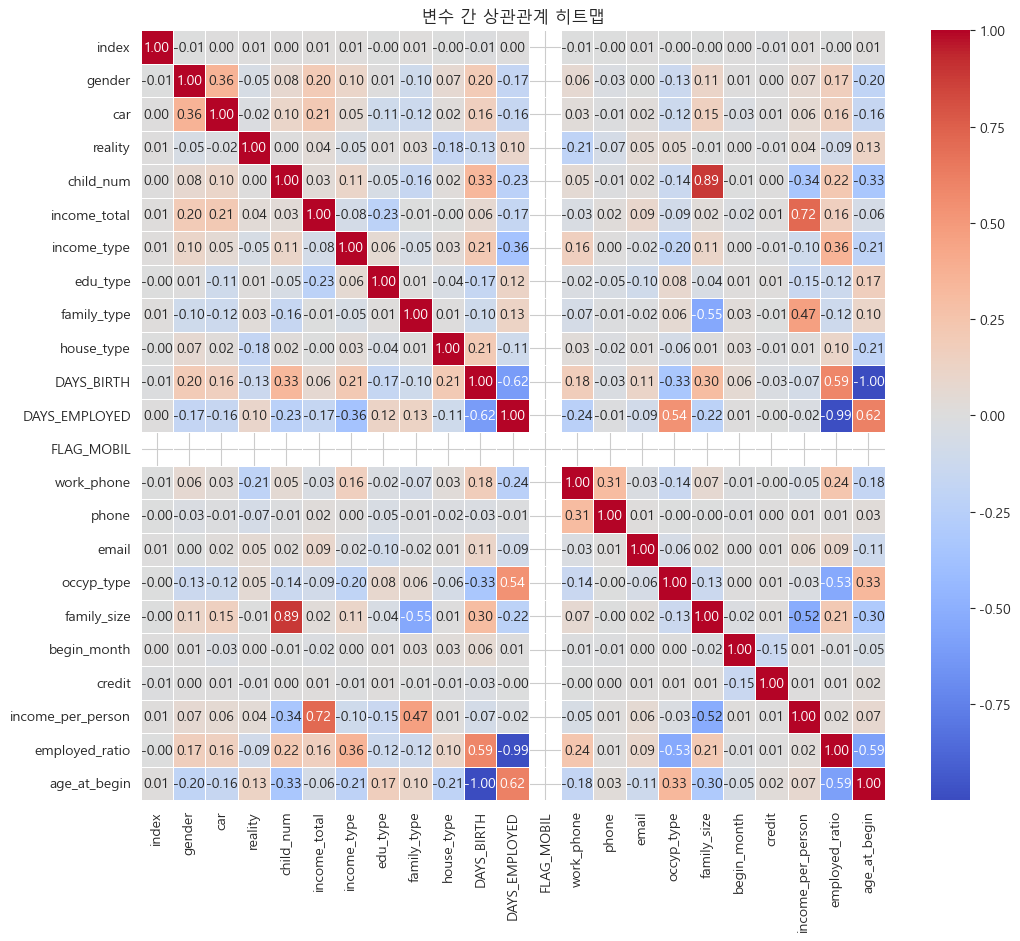

In [40]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('변수 간 상관관계 히트맵')
plt.show()

In [41]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# 1. 학습 데이터 준비
X = train.drop(['credit'], axis=1)
y = train['credit']
X_test = test.copy()

# 2. 교차 검증 설정 (5-Fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장용 리스트
oof_pred = np.zeros((train.shape[0], 3))
test_pred = np.zeros((test.shape[0], 3))

# 3. K-Fold 반복 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"===== Fold {fold+1} / 5 =====")
    
    # 데이터 분할
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 모델 정의
    model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        importance_type='gain'
    )
    
    # 모델 학습 (변경된 방식: callbacks 사용)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[
            lgb.early_stopping(stopping_rounds=100), # 100회 동안 개선 없으면 중단
            lgb.log_evaluation(period=100)           # 100회마다 결과 출력
        ]
    )
    
    # 검증 데이터 예측 및 기록
    oof_pred[val_idx] = model.predict_proba(X_val)
    
    # 테스트 데이터 예측값 누적 (평균)
    test_pred += model.predict_proba(X_test) / 5

# 4. 전체 검증 점수 확인
score = log_loss(y, oof_pred)
print(f"\n[최종 CV Logloss Score]: {score:.4f}")

===== Fold 1 / 5 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 21
[LightGBM] [Info] Start training from score -2.105723
[LightGBM] [Info] Start training from score -1.440314
[LightGBM] [Info] Start training from score -0.444119
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.807094
[200]	valid_0's multi_logloss: 0.788245
[300]	valid_0's multi_logloss: 0.779133
[400]	valid_0's multi_logloss: 0.772534
[500]	valid_0's multi_logloss: 0.766797
[600]	valid_0's multi_logloss: 0.762565
[700]	valid_0's multi_logloss: 0.758622
[800]	valid_0's multi_logloss: 0.755918
[900]	valid_0's multi_logloss: 0.753029
[1000]	valid_0's multi_logloss: 0.750703
Did not meet early stopping. Best iteration is:
[1000]	valid_0'

In [11]:
# 예측값 대입
submission.iloc[:, 1:] = test_pred

# 파일 저장
submission.to_csv('baseline_submission.csv', index=False)

print("제출 파일(baseline_submission.csv)이 생성되었습니다!")

제출 파일(baseline_submission.csv)이 생성되었습니다!


In [12]:
def create_id(df):
    # 동일 인물을 식별할 수 있는 컬럼들 조합
    # 성별, 생년월일, 소득, 직업, 고용일 등 7개 이상의 조건이 같으면 동일인으로 간주
    cols = ['gender', 'DAYS_BIRTH', 'income_total', 'income_type', 
            'DAYS_EMPLOYED', 'edu_type', 'family_type', 'house_type', 'occyp_type']
    
    # 각 행을 문자열로 이어붙여 고유 ID 생성
    df['ID'] = ""
    for col in cols:
        df['ID'] += df[col].astype(str) + '_'
    
    # ID별로 몇 개의 데이터(카드)가 있는지 카운트
    df['card_count'] = df.groupby('ID')['ID'].transform('count')
    
    # ID를 다시 숫자로 인코딩 (모델 학습용)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['ID'] = le.fit_transform(df['ID'])
    
    return df

train = create_id(train)
test = create_id(test)

print("ID 및 카드 개수 변수 생성 완료!")
train[['ID', 'card_count']].head()

ID 및 카드 개수 변수 생성 완료!


,ID,card_count
0,1582,5
1,525,9
2,7859,6
3,2078,2
4,2059,1


In [46]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import numpy as np

# 1. Optuna로 찾은 최적의 파라미터 설정
best_params = {
    'learning_rate': 0.012955353371935858,
    'num_leaves': 106,
    'max_depth': 14,
    'min_child_samples': 14,
    'subsample': 0.8673271377717254,
    'colsample_bytree': 0.501599556299356,
    'n_estimators': 2000,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1  # 경고 문구 출력 방지
}

# 2. 10-Fold 교차 검증 설정
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# 결과 저장용 리스트 (전체 학습 데이터 행수, 클래스 3개)
oof_pred = np.zeros((train.shape[0], 3))
test_pred = np.zeros((test.shape[0], 3))

# 3. K-Fold 반복 학습 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"===== Fold {fold+1} / {n_folds} =====")
    
    # 데이터 분할
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 모델 정의 (최적 파라미터 적용)
    model = LGBMClassifier(**best_params)
    
    # 모델 학습
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200) # 200회마다 출력하여 출력창 간소화
        ]
    )
    
    # 검증 데이터 예측 및 기록
    oof_pred[val_idx] = model.predict_proba(X_val)
    
    # 테스트 데이터 예측값 누적 (10개 모델의 평균)
    test_pred += model.predict_proba(X_test) / n_folds

# 4. 최종 결과 확인
final_cv_score = log_loss(y, oof_pred)
print(f"\n[기존 5-Fold Score]: 0.7428")
print(f"[최적화 + 10-Fold Score]: {final_cv_score:.4f}")

# 5. 제출 파일 생성
submission.iloc[:, 1:] = test_pred
submission.to_csv('final_lgbm_10fold.csv', index=False)
print("\n최종 제출 파일(final_lgbm_10fold.csv)이 저장되었습니다.")

===== Fold 1 / 10 =====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.749971
[400]	valid_0's multi_logloss: 0.724796
[600]	valid_0's multi_logloss: 0.712794
[800]	valid_0's multi_logloss: 0.706819
[1000]	valid_0's multi_logloss: 0.702788
[1200]	valid_0's multi_logloss: 0.701164
Early stopping, best iteration is:
[1286]	valid_0's multi_logloss: 0.700663
===== Fold 2 / 10 =====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.765586
[400]	valid_0's multi_logloss: 0.741659
[600]	valid_0's multi_logloss: 0.72866
[800]	valid_0's multi_logloss: 0.720363
[1000]	valid_0's multi_logloss: 0.714096
[1200]	valid_0's multi_logloss: 0.712016
Early stopping, best iteration is:
[1193]	valid_0's multi_logloss: 0.711966
===== Fold 3 / 10 =====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.765189
[400]	valid_0's multi_logloss: 0.741614
[600]	valid_0's multi_loglo

In [49]:
submission

,index,0,1,2
0,26457,0.005078,0.165956,0.828966
1,26458,0.059038,0.163130,0.777832
2,26459,0.017264,0.121450,0.861286
3,26460,0.092194,0.154259,0.753547
4,26461,0.044575,0.271420,0.684005
...,...,...,...,...
9995,36452,0.026081,0.311365,0.662554
9996,36453,0.025915,0.325564,0.648521
9997,36454,0.012380,0.054598,0.933022
9998,36455,0.027526,0.291826,0.680648


In [44]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def objective(trial):
    # 탐색할 파라미터 범위 설정
    param = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }

    # 데이터 분할 (튜닝을 위해 간단히 분할)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = LGBMClassifier(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)] # 로그 출력 생략
    )
    
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

# 최적화 실행 (30회 시도)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print(f"\n최고의 Logloss: {study.best_value:.4f}")
print("최적의 파라미터:", study.best_params)

[I 2026-02-28 15:28:25,286] A new study created in memory with name: no-name-6bd273e9-e1d3-4723-bb53-97c4ce0184d3


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[923]	valid_0's multi_logloss: 0.731129


[I 2026-02-28 15:29:14,993] Trial 0 finished with value: 0.7311285922598119 and parameters: {'learning_rate': 0.01734503199938195, 'num_leaves': 82, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.752573391730226, 'colsample_bytree': 0.5754668121390053}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	valid_0's multi_logloss: 0.73632


[I 2026-02-28 15:29:41,884] Trial 1 finished with value: 0.7363200072133459 and parameters: {'learning_rate': 0.02876659447873139, 'num_leaves': 125, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.8642391959593405, 'colsample_bytree': 0.7696426020503386}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[889]	valid_0's multi_logloss: 0.753627


[I 2026-02-28 15:29:51,932] Trial 2 finished with value: 0.7536268905984661 and parameters: {'learning_rate': 0.04095290912469278, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.5455306445787198, 'colsample_bytree': 0.9722375213240202}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.76247


[I 2026-02-28 15:30:29,240] Trial 3 finished with value: 0.7624703031199898 and parameters: {'learning_rate': 0.007069219278633861, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5039158589605298, 'colsample_bytree': 0.9924864475262566}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.761142


[I 2026-02-28 15:30:47,483] Trial 4 finished with value: 0.7611421242057971 and parameters: {'learning_rate': 0.020523532655593497, 'num_leaves': 42, 'max_depth': 4, 'min_child_samples': 33, 'subsample': 0.9958774600176906, 'colsample_bytree': 0.8990709214205119}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1993]	valid_0's multi_logloss: 0.77694


[I 2026-02-28 15:31:00,494] Trial 5 finished with value: 0.7769402475485866 and parameters: {'learning_rate': 0.020599100089471283, 'num_leaves': 135, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.9714111216371344, 'colsample_bytree': 0.5625337518441709}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[923]	valid_0's multi_logloss: 0.750937


[I 2026-02-28 15:31:19,799] Trial 6 finished with value: 0.75093660576131 and parameters: {'learning_rate': 0.03520321782695515, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 47, 'subsample': 0.9118887120551793, 'colsample_bytree': 0.5016783600077704}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1784]	valid_0's multi_logloss: 0.761452


[I 2026-02-28 15:31:34,365] Trial 7 finished with value: 0.7614522613603891 and parameters: {'learning_rate': 0.026737633118584285, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9658430293090408, 'colsample_bytree': 0.8383399692260358}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.749201


[I 2026-02-28 15:31:50,611] Trial 8 finished with value: 0.7492012623536254 and parameters: {'learning_rate': 0.03297078754178256, 'num_leaves': 136, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.6420444531129403, 'colsample_bytree': 0.8671087534303903}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.783687


[I 2026-02-28 15:32:02,654] Trial 9 finished with value: 0.7836874599239506 and parameters: {'learning_rate': 0.013804478548072412, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 36, 'subsample': 0.924789708794244, 'colsample_bytree': 0.7503381543870318}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.763666


[I 2026-02-28 15:32:36,782] Trial 10 finished with value: 0.7636662468241725 and parameters: {'learning_rate': 0.00545359121948579, 'num_leaves': 22, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.7719198808394517, 'colsample_bytree': 0.6317155584846481}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's multi_logloss: 0.732728


[I 2026-02-28 15:33:07,913] Trial 11 finished with value: 0.7327282700602963 and parameters: {'learning_rate': 0.0242595258795868, 'num_leaves': 107, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.8172729745173234, 'colsample_bytree': 0.6946190527514492}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.738764


[I 2026-02-28 15:33:19,877] Trial 12 finished with value: 0.7387636672658814 and parameters: {'learning_rate': 0.047951378420390864, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7603743862467426, 'colsample_bytree': 0.6518478158615928}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[568]	valid_0's multi_logloss: 0.7341


[I 2026-02-28 15:34:01,084] Trial 13 finished with value: 0.7340996226734959 and parameters: {'learning_rate': 0.017788700402264275, 'num_leaves': 110, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.6893861446974079, 'colsample_bytree': 0.6287090181321219}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1098]	valid_0's multi_logloss: 0.739533


[I 2026-02-28 15:34:42,779] Trial 14 finished with value: 0.7395334432565417 and parameters: {'learning_rate': 0.013481572721407698, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.8252804579380149, 'colsample_bytree': 0.6859559262359994}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's multi_logloss: 0.737326


[I 2026-02-28 15:35:13,059] Trial 15 finished with value: 0.7373263906036999 and parameters: {'learning_rate': 0.024566986550161804, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.6934515681329015, 'colsample_bytree': 0.5268057826831001}. Best is trial 0 with value: 0.7311285922598119.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[929]	valid_0's multi_logloss: 0.730283


[I 2026-02-28 15:36:11,899] Trial 16 finished with value: 0.7302826170672266 and parameters: {'learning_rate': 0.013015471692109738, 'num_leaves': 110, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.8337021198489606, 'colsample_bytree': 0.583849034803974}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1013]	valid_0's multi_logloss: 0.735914


[I 2026-02-28 15:37:17,873] Trial 17 finished with value: 0.7359140351241766 and parameters: {'learning_rate': 0.012093176739755539, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6221902855308414, 'colsample_bytree': 0.5937227321620542}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1409]	valid_0's multi_logloss: 0.730652


[I 2026-02-28 15:38:29,013] Trial 18 finished with value: 0.7306515391844215 and parameters: {'learning_rate': 0.009781784185148301, 'num_leaves': 84, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.7113432926619059, 'colsample_bytree': 0.5757489715601602}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[893]	valid_0's multi_logloss: 0.73431


[I 2026-02-28 15:39:37,087] Trial 19 finished with value: 0.7343100909052709 and parameters: {'learning_rate': 0.009020468712676363, 'num_leaves': 150, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.6960575252957215, 'colsample_bytree': 0.7964551899983882}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1689]	valid_0's multi_logloss: 0.734899


[I 2026-02-28 15:40:40,248] Trial 20 finished with value: 0.7348992423989744 and parameters: {'learning_rate': 0.010091041660492687, 'num_leaves': 57, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.827439047718832, 'colsample_bytree': 0.7094808639327208}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[853]	valid_0's multi_logloss: 0.733151


[I 2026-02-28 15:41:35,815] Trial 21 finished with value: 0.7331512032136382 and parameters: {'learning_rate': 0.01715565740093406, 'num_leaves': 86, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.7536342742441476, 'colsample_bytree': 0.5647399013726784}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[804]	valid_0's multi_logloss: 0.736876


[I 2026-02-28 15:42:20,195] Trial 22 finished with value: 0.7368757805183935 and parameters: {'learning_rate': 0.015986038243933978, 'num_leaves': 84, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.7147712058336149, 'colsample_bytree': 0.5835937622215432}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[758]	valid_0's multi_logloss: 0.736422


[I 2026-02-28 15:42:52,575] Trial 23 finished with value: 0.7364216234068258 and parameters: {'learning_rate': 0.020343807967025174, 'num_leaves': 73, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.642855909663823, 'colsample_bytree': 0.5527616545416977}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1211]	valid_0's multi_logloss: 0.730591


[I 2026-02-28 15:44:12,561] Trial 24 finished with value: 0.7305910000593234 and parameters: {'learning_rate': 0.010276677562892963, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7939162416271315, 'colsample_bytree': 0.6131451609534774}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1959]	valid_0's multi_logloss: 0.737025


[I 2026-02-28 15:46:06,516] Trial 25 finished with value: 0.7370252106678074 and parameters: {'learning_rate': 0.0056703413584560675, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.8680405047883291, 'colsample_bytree': 0.6247800125070535}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1433]	valid_0's multi_logloss: 0.74217


[I 2026-02-28 15:47:18,005] Trial 26 finished with value: 0.7421704266858332 and parameters: {'learning_rate': 0.00931347145917723, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.787583594177891, 'colsample_bytree': 0.660946051157262}. Best is trial 16 with value: 0.7302826170672266.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[923]	valid_0's multi_logloss: 0.730023


[I 2026-02-28 15:48:21,292] Trial 27 finished with value: 0.7300229727483525 and parameters: {'learning_rate': 0.012955353371935858, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.8673271377717254, 'colsample_bytree': 0.501599556299356}. Best is trial 27 with value: 0.7300229727483525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[975]	valid_0's multi_logloss: 0.730852


[I 2026-02-28 15:49:26,415] Trial 28 finished with value: 0.7308518769889697 and parameters: {'learning_rate': 0.013421625301763296, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8680899091834808, 'colsample_bytree': 0.5089345339146384}. Best is trial 27 with value: 0.7300229727483525.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[669]	valid_0's multi_logloss: 0.737575


[I 2026-02-28 15:50:12,093] Trial 29 finished with value: 0.7375752760326637 and parameters: {'learning_rate': 0.015684627908643542, 'num_leaves': 126, 'max_depth': 14, 'min_child_samples': 43, 'subsample': 0.9003411453188559, 'colsample_bytree': 0.5372943054732707}. Best is trial 27 with value: 0.7300229727483525.



최고의 Logloss: 0.7300
최적의 파라미터: {'learning_rate': 0.012955353371935858, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.8673271377717254, 'colsample_bytree': 0.501599556299356}


In [45]:
study.best_params

{'learning_rate': 0.012955353371935858,
 'num_leaves': 106,
 'max_depth': 14,
 'min_child_samples': 14,
 'subsample': 0.8673271377717254,
 'colsample_bytree': 0.501599556299356}